In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import os
import os
import numpy as np
import matplotlib.pyplot as plt
from pyemma.coordinates import tica
import warnings
warnings.filterwarnings("ignore")
plt.style.use(['science','no-latex'])
name_dict = {'pre': 'QM (1k) Training',
             'post_cycle1': 'QM (1k) + 1 Cycle Observable Training',
             'post_cycle2': 'QM (1k) + 2 Cycles Observable Training',
             'post_cycle3': 'QM (1k) + 2 Cycles Observable Training',
             'post': 'QM (1k) + Observable Training',
             '10k': 'QM (10k) Training',
             '50k': 'QM (50k) Training'}
import matplotlib.pylab as pylab
params = {'figure.dpi': 600,
            'axes.labelsize': 'small',
          'legend.fontsize': 'x-small',
         'axes.titlesize':'small',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

            
def plot_stability_distribution(molecule, exp_dir):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure()
    for name in os.listdir(inference_dir):
        if "pre" in name or "cycle2" in name: #temporary
            stab = np.load(os.path.join(inference_dir, name, 'replicas_stable_time.npy'))
            plt.hist(stab, bins = 50, label = name_dict[name], density=True, alpha=0.7)
    plt.title(molecule[0].upper() + molecule[1:], fontsize=18)
    plt.legend(loc = 'upper right')
    plt.xlabel(f"Stable Simulation Time (ps)", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    

def plot_observable_mae_distribution(molecule, exp_dir, observable = 'rdf'):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure()
    for name in os.listdir(inference_dir):
        if "cycle" not in name: #temporary
            maes = np.load(os.path.join(inference_dir, name, f'final_{observable}_maes.npy'))
            plt.hist(maes, bins = 50, label = name_dict[name], density=True, alpha=0.7)
    plt.title(molecule[0].upper() + molecule[1:], fontsize=18)
    plt.legend(loc = 'upper right')
    plt.xlabel(f"{observable.upper()} MAE", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    

def plot_observable_mae_difference_distribution(molecule, exp_dir, observable = 'rdf'):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure()
    for name in os.listdir(inference_dir):
        pre_maes = np.load(os.path.join(inference_dir, "pre", f'final_{observable}_maes.npy'))
        if "post" in name and "pre" not in name and "cycle" not in name: #temporary
            maes = np.load(os.path.join(inference_dir, name, f'final_{observable}_maes.npy'))
            plt.hist(100*(maes - pre_maes)/pre_maes, bins = 50, label = name_dict[name], density=True, alpha=0.7)
    plt.title(molecule[0].upper() + molecule[1:], fontsize=18)
    #plt.legend(loc = 'upper left')
    plt.xlabel(f"Change in {observable.upper()} MAE after Observable Training (%)", fontsize=8)
    plt.ylabel("Frequency", fontsize=14)
    
def plot_observable(molecule, exp_dir, observable = 'rdf', diff = False):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure()
    pre_maes = np.load(os.path.join(inference_dir, "pre", f'final_{observable}_maes.npy'))
    pre_obs = np.load(os.path.join(inference_dir, "pre", f'final_{observable}s.npy'))
    gt_obs = np.load(os.path.join(inference_dir, "pre", f'gt_{observable}.npy'))
    if observable == 'rdf':
        gt_obs /=2
        x_axis = np.linspace(0, 10, 500)
    elif observable == 'adf':
        x_axis = np.linspace(0, np.pi, 180)
    elif observable == 'vacf':
        x_axis = np.linspace(0, 50, 100)
    
    for name in os.listdir(inference_dir):
        if "post" in name and "pre" not in name and "cycle" not in name: #temporary
            maes = np.load(os.path.join(inference_dir, name, f'final_{observable}_maes.npy'))
            obs = np.load(os.path.join(inference_dir, name, f'final_{observable}s.npy'))
            percent_change = 100*(maes - pre_maes)/pre_maes
            mean_percent_change = percent_change.mean()
            mean_replica = np.argmin(np.abs(percent_change - mean_percent_change))
            if diff:
                #print(100*(obs[mean_replica] - gt_obs)/(gt_obs + 1e-8))
                plt.plot(x_axis, obs[mean_replica] - gt_obs, label=name_dict[name], color = 'orange')
            else:
                plt.plot(x_axis, obs[mean_replica], label=name_dict[name], color = 'orange')
    if diff:
        plt.plot(x_axis, pre_obs[mean_replica] - gt_obs, label=name_dict["pre"], color = 'blue')
    else:
        plt.plot(x_axis, pre_obs[mean_replica], label=name_dict["pre"], color = 'blue')
    if not diff:
        plt.plot(x_axis, gt_obs, label="Ground Truth", color = 'green')
    if observable == 'rdf':
        xlabel = "r (Angstroms)"
        ylabel = "h(r)"
        title  = "Distribution of Interatomic Distances"
    elif observable == 'adf':
        xlabel = "Angle (radians)"
        ylabel = "ADF"
        title  = "Angular Distribution Function"
    elif observable == 'vacf':
        xlabel = "Time lag (fs)"
        ylabel = "Normalized VACF"
        title  = "Velocity Autocorrelation Function"
    
    if diff:
        title +=" - Diff"
        ylabel +=" - Diff"
    
    plt.title(molecule[0].upper() + molecule[1:] + ": " + title, fontsize=12)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc = 'upper right')
    

def plot_tic(molecule, exp_dir, gt_dir):
    LAG = 50
    gt_traj = np.load(gt_dir)
    
    gt_traj = gt_traj.f.R.reshape(gt_traj.f.R.shape[0] , -1)
    projected_data_gt = tica(gt_traj, lag=LAG, dim=2).get_output()[0]
    pred_traj = np.load(os.path.join(exp_dir, 'inference', 'post', 'full_traj.npy'))
    
    #this is incorrect because we have multiple replicas - need to somehow average over many trajectories
    pred_traj = pred_traj.reshape(pred_traj.shape[0]*pred_traj.shape[1], -1)
    projected_data_pred = tica(gt_traj, lag=int(LAG/50), dim=2).get_output()[0]
    
    # Determine common color scale limits
    h1, _, _ = np.histogram2d(projected_data_gt[:, 0], projected_data_gt[:, 1], bins=(100, 100))
    h2, _, _ = np.histogram2d(projected_data_pred[:, 0], projected_data_pred[:, 1], bins=(100, 100))
    vmin = min(h1.min(), h2.min())
    vmax = max(h1.max(), h2.max())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot data on the first axis
    c1 = ax1.hist2d(projected_data_gt[:, 0], projected_data_gt[:, 1], bins=(100, 100), vmin=vmin, vmax=vmax, cmap = 'viridis')
    ax1.set_xlabel("TIC1", fontsize=14)
    ax1.set_ylabel("TIC2", fontsize=14)
    ax1.set_title('Reference', fontsize=18)

    # Plot data on the second axis
    c2 = ax2.hist2d(projected_data_pred[:, 0], projected_data_pred[:, 1], bins=(100, 100), vmin=vmin, vmax=vmax, cmap = 'viridis')
    ax2.set_xlabel("TIC1", fontsize=14)
    ax2.set_ylabel("TIC2", fontsize=14)
    ax2.set_title('Finetuned Schnet model', fontsize=18)

    # Add a single colorbar to the figure
    fig.colorbar(c1[3], ax=[ax1, ax2], orientation='vertical', pad=0.05)
    plt.show()


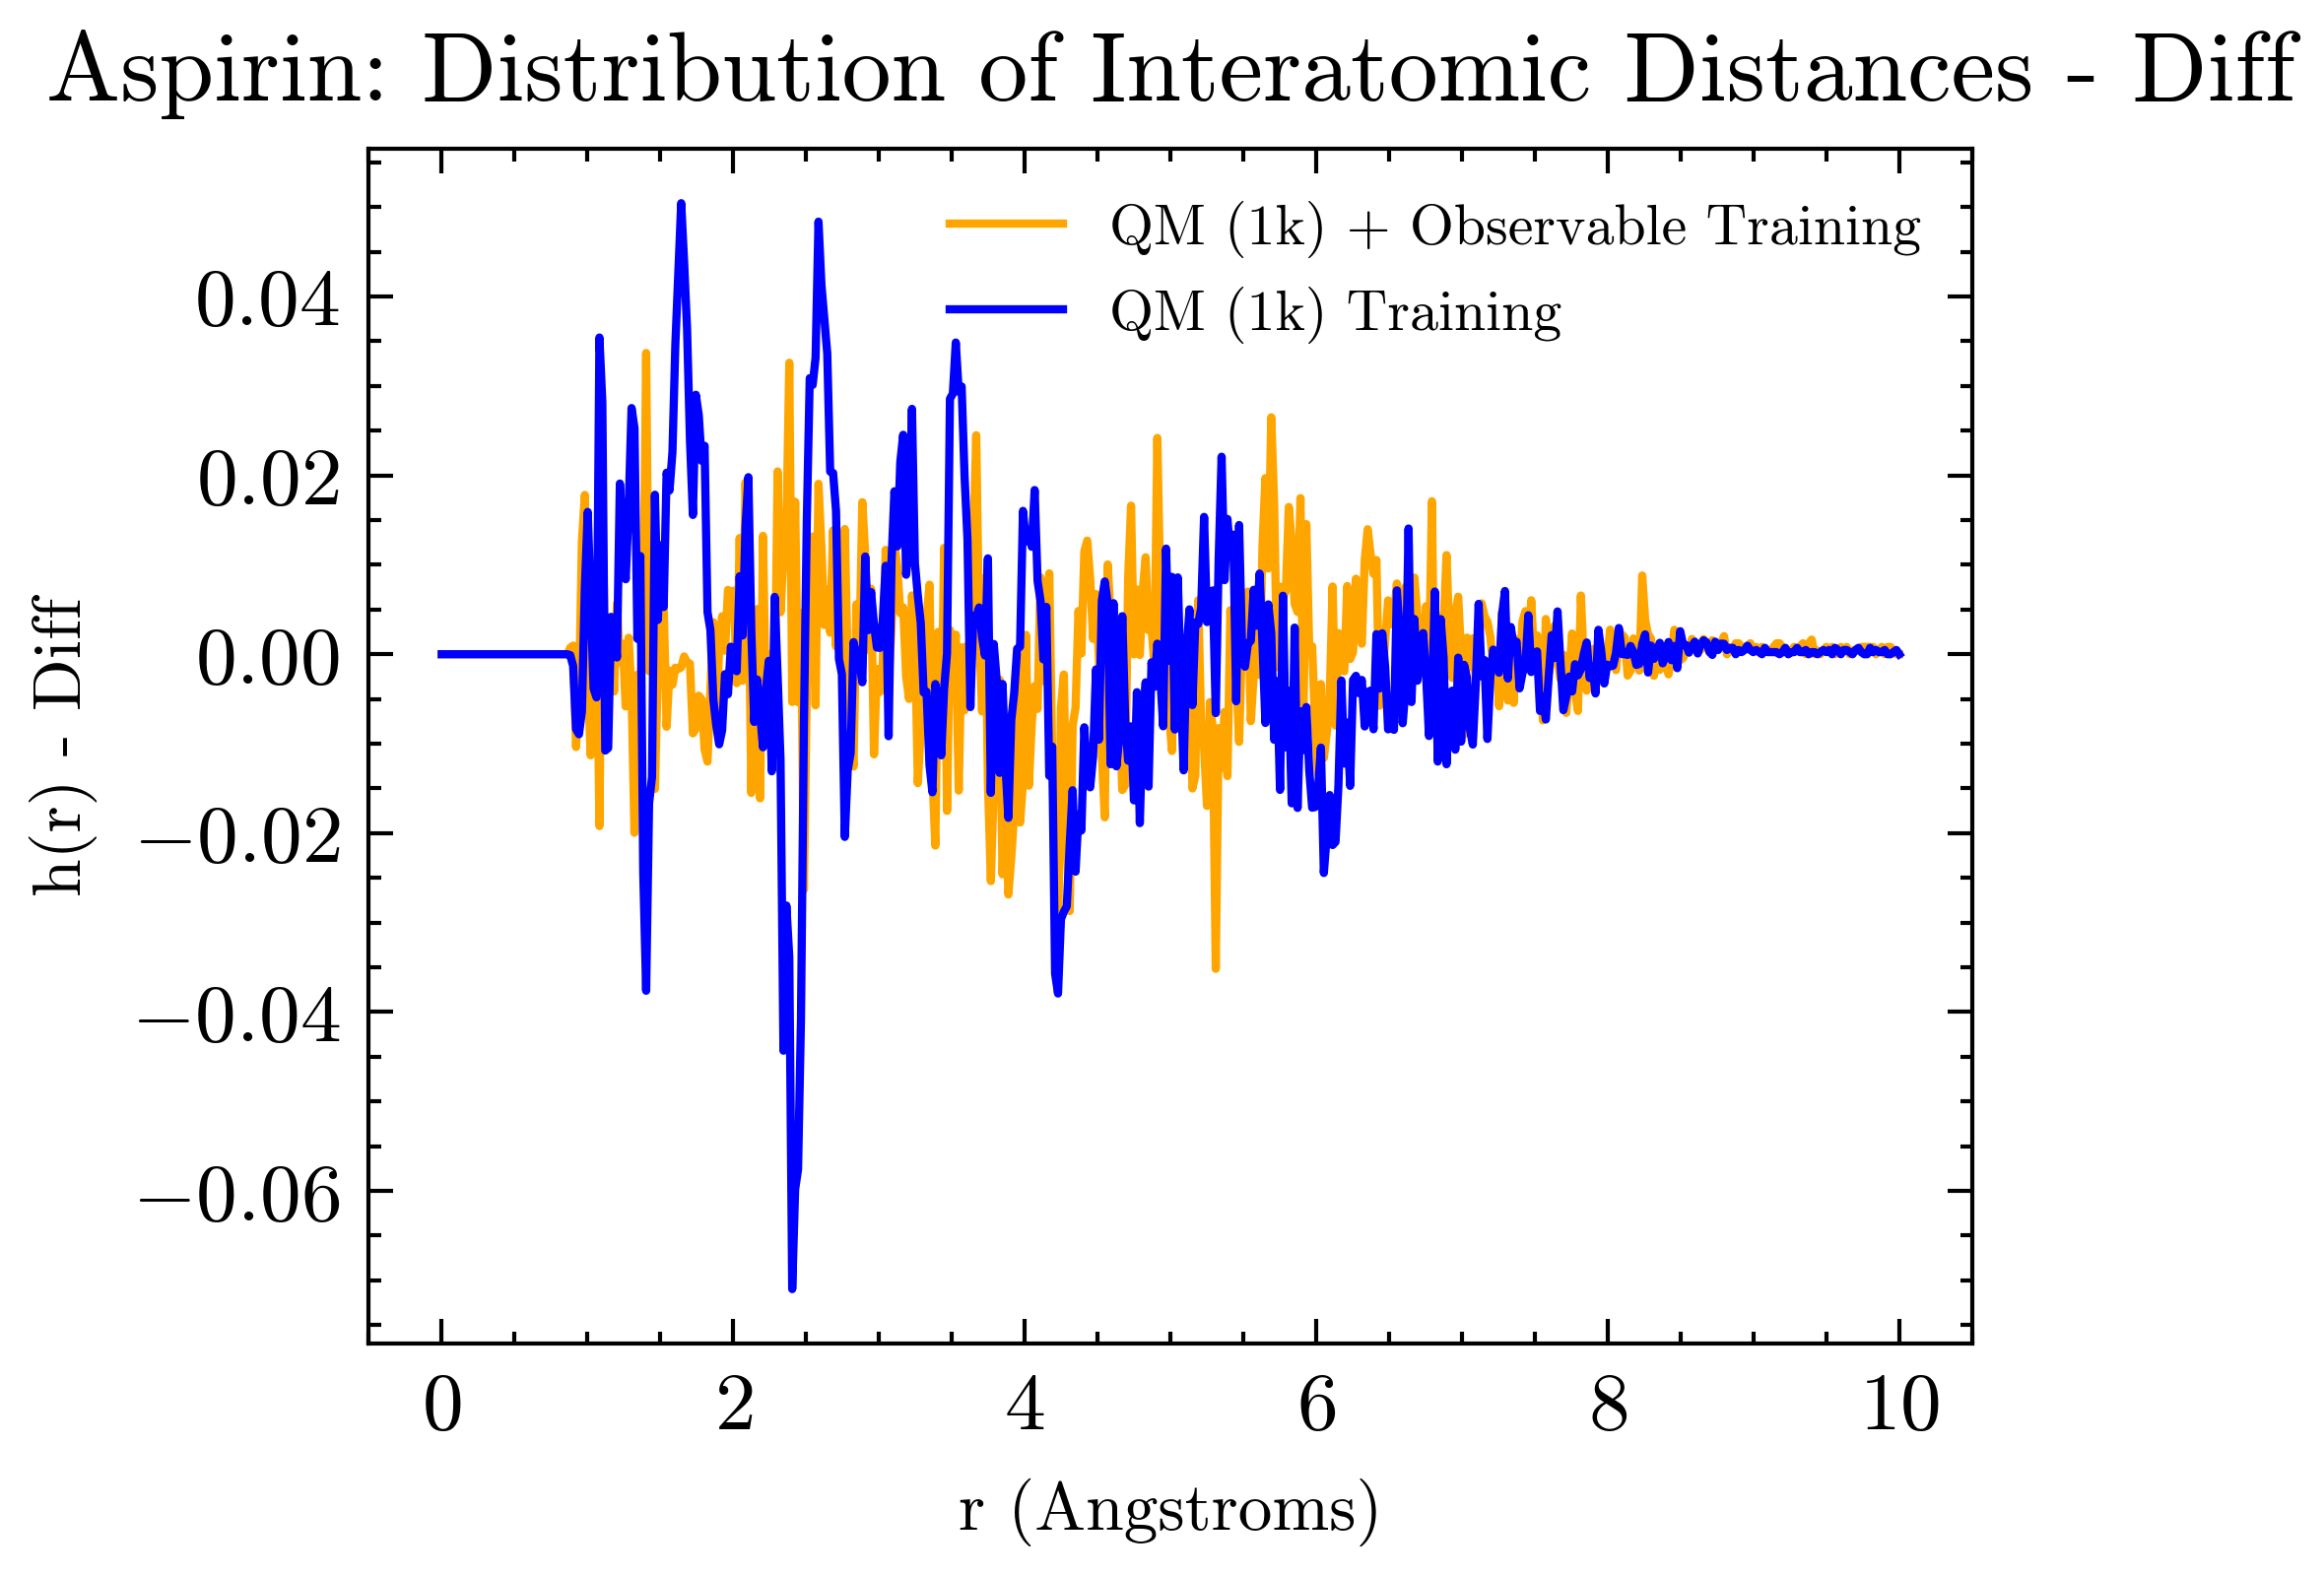

In [2]:
molecule = 'aspirin'
exp_dir = '/global/cfs/projectdirs/m4319/sanjeevr/results_md17_correctedlogging/IMPLICIT_schnet_aspirin_TEST_correctedlogging_lr=0.001_efweight=10'
gt_dir = f'/data/sanjeevr/contiguous-md17/{molecule}/10k/val/nequip_npz.npz'
plot_stability_distribution(molecule, exp_dir)
#plot_observable_mae_distribution(molecule, exp_dir, 'rdf')
#plot_observable_mae_distribution(molecule, exp_dir, 'adf')
#plot_observable_mae_distribution(molecule, exp_dir, 'vacf')
#plot_observable_mae_difference_distribution(molecule, exp_dir, 'vacf')
#plot_observable(molecule, exp_dir, 'vacf', diff=True)
#plot_observables_combined(molecule, exp_dir)
#plot_tic(molecule, exp_dir, gt_dir)
